# Mosaico / Anatel

[![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/intrig-unicamp/hackathon5G/main?labpath=/datasets/mosaico.ipynb)
[![nbviewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/intrig-unicamp/hackathon5G/blob/main/datasets/mosaico.ipynb)

Esse Notebook contém uma breve análise dos dados que o Mosaico dispõe. Os participantes são encorajados a experimentar com os dados para descobrir padrões, formas de resolver problemas no contexto da Hackathon.

O Mosaico é um sistema da Agência Nacional de Telecomunicações (Anatel) que contém informações sobre todas as estações de telecomunicações registradas no Brasil. O sistema é utilizado para monitorar e controlar o espectro de frequências utilizado pelas operadoras de telecomunicações e outras empresas que possuem licenças para operar estações em território nacional. Entre os dados armazenados no Mosaico estão informações sobre os proprietários das estações, as tecnologias e equipamentos utilizados, as frequências de transmissão e recepção, a localização geográfica das estações e as datas de licenciamento e validade. O Mosaico é uma ferramenta importante para a ANATEL e outras autoridades regulatórias que precisam monitorar e controlar o uso do espectro de frequências de telecomunicações no Brasil, garantindo que as operadoras e outras empresas cumpram as regulamentações e leis aplicáveis.

Os dados utilizados nesse Notebook foram extraídos [desse](https://sistemas.anatel.gov.br/se/public/view/b/licenciamento.php?view=licenciamento) endereço (Mosaico).

<center>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/Telstra_Mobile_Phone_Tower.jpg/399px-Telstra_Mobile_Phone_Tower.jpg' height='300' /><br />
<i>Um exemplo de ERB (Estação Rádio Base). Observe que uma ERB é composta por vários equipamentos de comunicação ("antenas")</i>
</center>

## Importando dependências globais

In [2]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances

from math import radians
import requests
import json
import random

random.seed(42)
pd.set_option('display.max_columns', None)

def pd_insert_beside(df, column_name, value):
    df.insert(df.columns.get_loc(value.name) + 1, column_name, value)

## Carregando os dados

In [3]:
DATA_PATH_PREFIX = '.'
MOSAICO_PATH = f'{DATA_PATH_PREFIX}/mosaico'

In [4]:
regions = [
    'são-paulo',
    'campinas',
    'rio-de-janeiro',
    'brasília',
]

ERBs = pd.concat([ pd.read_csv(f'{MOSAICO_PATH}/mosaico-erbs-{region}.zip', encoding='iso-8859-1', low_memory=False) for region in regions ], ignore_index=True).copy()

## Normalização dos valores

Na célula abaixo, identificamos os possíveis valores da coluna `Tecnologia`, em seguida, os normalizamos e criamos outro campo com o mapeamento para a geração da tecnologia (_e.g._ `LTE` → `4G`, `NR` → `5G`)

In [5]:
ERBs.Tecnologia.unique()

array(['WCDMA', 'GSM', 'LTE', 'NR', 'CDMA', nan, 'DMR', 'VHF', 'UHF',
       '0.0', 'TETRA', 'DMR - Tyer 2', 'WDCMA', 'NR ', 'LTE ', 'EDGE',
       'UMTS', 'Tetra'], dtype=object)

In [6]:
ERBs.replace({ 'Tecnologia': { 'NR ': 'NR', 'WDCMA': 'WCDMA' } }, inplace=True)
pd_insert_beside(ERBs, 'Tecnologia_gen', ERBs.Tecnologia.map({ 'GSM': '2G', 'WCDMA': '3G', 'LTE': '4G', 'NR': '5G' }))

A seguir, normalizamos os valores do azimute (em graus) e criamos um novo campo com o azimute em radianos

In [7]:
ERBs.Azimute = ERBs.Azimute.str.replace(',', '.').replace('V', np.nan).astype(np.float64)
pd_insert_beside(ERBs, 'Azimute_rad', ERBs.Azimute.apply(lambda val: val * np.pi/180))

O Dataframe resultante é o seguinte:

In [8]:
ERBs

Status.state            NomeEntidade    NumFistel  NumServico   
0         LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146447          10  \
1         LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146447          10   
2         LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146447          10   
3         LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146447          10   
4         LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146447          10   
...              ...                     ...          ...         ...   
1218865   LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146366          10   
1218866   LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146366          10   
1218867   LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146366          10   
1218868   LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146366          10   
1218869   LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146366          10   

             NumAto  NumEstacao               EnderecoEstacao EndComplemento   
0        17012008.0      122700  Rua Manoel Duque de Carvalho            NaN  \
1        35312011.0      122700  Rua Manoel Duque de Carvalho            NaN   
2        35312011.0      122700  Rua Manoel Duque de Carvalho            NaN   
3        35312011.0      122700  Rua Manoel Duque de Carvalho            NaN   
4        35312011.0      122700  Rua Manoel Duque de Carvalho            NaN   
...             ...         ...                           ...            ...   
1218865  35312011.0  1014783507      SHIS QI. 12 CONJUNTO 8/9            NaN   
1218866  17012008.0  1014783507      SHIS QI. 12 CONJUNTO 8/9            NaN   
1218867  17012008.0  1014783507      SHIS QI. 12 CONJUNTO 8/9            NaN   
1218868  50852013.0  1014783507      SHIS QI. 12 CONJUNTO 8/9            NaN   
1218869  50852013.0  1014783507      SHIS QI. 12 CONJUNTO 8/9            NaN   

        SiglaUf  CodMunicipio DesignacaoEmissao Tecnologia Tecnologia_gen   
0            SP       3550308           5M00G9W      WCDMA             3G  \
1            SP       3550308           200KG7W        GSM             2G   
2            SP       3550308           200KG7W        GSM             2G   
3            SP       3550308           200KG7W        GSM             2G   
4            SP       3550308           200KG7W        GSM             2G   
...         ...           ...               ...        ...            ...   
1218865      DF       5300108           10M0G7W        LTE             4G   
1218866      DF       5300108           10M0G7W        LTE             4G   
1218867      DF       5300108           10M0G7W        LTE             4G   
1218868      DF       5300108           5M00G7W        LTE             4G   
1218869      DF       5300108           5M00G7W        LTE             4G   

        tipoTecnologia  meioAcesso  FreqTxMHz  FreqRxMHz  Azimute   
0                  NaN         NaN     2160.0     1970.0    230.0  \
1                  NaN         NaN     1862.5     1767.5    360.0   
2                  NaN         NaN     1862.5     1767.5    130.0   
3                  NaN         NaN     1867.5     1772.5    130.0   
4                  NaN         NaN     1867.5     1772.5    240.0   
...                ...         ...        ...        ...      ...   
1218865            NaN         NaN     1855.0     1760.0      NaN   
1218866            NaN         NaN     2160.0     1970.0      NaN   
1218867            NaN         NaN     2160.0     1970.0      NaN   
1218868            NaN         NaN     2167.5     1977.5      NaN   
1218869            NaN         NaN     2167.5     1977.5      NaN   

         Azimute_rad CodTipoClasseEstacao ClassInfraFisica   
0           4.014257                   FB              NaN  \
1           6.283185                   FB              NaN   
2           2.268928                   FB              NaN   
3           2.268928                   FB              NaN   
4           4.188790                   FB              NaN   
...              ...                  ...   

# Colunas

Estão disponíveis as seguintes colunas (agrupadas logicamente):

- **Identificação**: `NomeEntidade`, `NumEstacao`;

- **Rádio**: `Tecnologia` (também disponível como `Tecnologia_gen`), `tipoTecnologia`, `FreqTxMHz`, `FreqRxMHz`, `DesignacaoEmissao`, `meioAcesso`, `Polarizacao`, `GanhoAntena`, `PotenciaTransmissorWatts`, `AnguloMeiaPotenciaAntena`, `FrenteCostaAntena`;

- **Posicionamento**: `Azimute` (também disponível como `Azimute_rad`), `AlturaAntena`, `AnguloElevacao`;

- **Localização**: `Latitude`, `Longitude`, `EnderecoEstacao`, `EndComplemento`, `SiglaUf`, `CodMunicipio`;

- **Regulamentação e Licenciamento**: `NumFistel`, `NumFistelAssociado`, `NumAto`, `DataLicenciamento`, `DataPrimeiroLicenciamento`, `DataValidade`, `CodDebitoTFI`;

- _Outros_: `CodTipoClasseEstacao`, `ClassInfraFisica`, `CompartilhamentoInfraFisica`, `CodTipoAntena`, `CodEquipamentoAntena`, `CodEquipamentoTransmissor`, `NumRede`, `NumServico`, `NomeEntidadeAssociado`, `Status.state`, `_id`.

# Exploração

Observe a quantidade de antenas nos Estados SP, RJ e DF

In [9]:
ERBs.groupby(['Tecnologia_gen', 'tipoTecnologia', 'SiglaUf'], dropna=False).count()[['_id']]

_id
Tecnologia_gen tipoTecnologia SiglaUf        
2G             NaN            DF         7681
                              RJ        21799
                              SP        24627
3G             NaN            DF        18362
                              RJ        37605
                              SP        51062
4G             NaN            DF        26180
                              RJ        57513
                              SP        87937
5G             NSA            DF          924
                              RJ            9
                              SP          591
               SA             DF          273
                              SP           33
               SA-NSA         DF         3091
                              RJ         6661
                              SP        12851
               NaN            DF           81
                              RJ          564
                              SP          598
NaN            0.0            SP           12
               DMR Tyer 2     RJ            7
                              SP            2
               NaN            DF        48373
                              RJ       127766
                              SP       684268

Procuramos pelas ERBs da operadora Claro

In [10]:
ERBs.NomeEntidade[(ERBs.NomeEntidade.str.contains('claro', case=False))].unique()

array(['CLARO S.A.'], dtype=object)

Filtramos pelas ERBs da operadora Claro no Estado de SP

In [11]:
ERBs_SP_CLARO = ERBs[(ERBs.SiglaUf == 'SP') & (ERBs.NomeEntidade == 'CLARO S.A.')].copy()
ERBs_SP_CLARO

Status.state NomeEntidade    NumFistel  NumServico       NumAto   
200      LIC-LIC-01   CLARO S.A.  50409105090          10   46662011.0  \
201      LIC-LIC-01   CLARO S.A.  50409105090          10   46662011.0   
202      LIC-LIC-01   CLARO S.A.  50409105090          10   46662011.0   
203      LIC-LIC-01   CLARO S.A.  50409105090          10   46662011.0   
204      LIC-LIC-01   CLARO S.A.  50409105090          10   46662011.0   
...             ...          ...          ...         ...          ...   
861976   LIC-LIC-01   CLARO S.A.  50409105090          10  105752021.0   
861977   LIC-LIC-01   CLARO S.A.  50409105090          10  105752021.0   
861978   LIC-LIC-01   CLARO S.A.  50409105090          10  105752021.0   
861979   LIC-LIC-01   CLARO S.A.  50409105090          10  105752021.0   
861980   LIC-LIC-01   CLARO S.A.  50409105090          10  105752021.0   

        NumEstacao             EnderecoEstacao          EndComplemento   
200        1246232  R GASPAR GONÇALVES RIBEIRO                       0  \
201        1246232  R GASPAR GONÇALVES RIBEIRO                       0   
202        1246232  R GASPAR GONÇALVES RIBEIRO                       0   
203        1246232  R GASPAR GONÇALVES RIBEIRO                       0   
204        1246232  R GASPAR GONÇALVES RIBEIRO                       0   
...            ...                         ...                     ...   
861976  1004778756          RUA MARIA MONTEIRO  ED PERO VAZ DE CAMINHA   
861977  1004778756          RUA MARIA MONTEIRO  ED PERO VAZ DE CAMINHA   
861978  1007421077           RUA LUIZ DE PAULA                     NaN   
861979  1007421077           RUA LUIZ DE PAULA                     NaN   
861980  1007421077           RUA LUIZ DE PAULA                     NaN   

       SiglaUf  CodMunicipio DesignacaoEmissao Tecnologia Tecnologia_gen   
200         SP       3550308           5M00G7W      WCDMA             3G  \
201         SP       3550308           5M00G7W      WCDMA             3G   
202         SP       3550308           5M00G7W      WCDMA             3G   
203         SP       3550308           5M00G7W      WCDMA             3G   
204         SP       3550308           200KG7W        GSM             2G   
...        ...           ...               ...        ...            ...   
861976      SP       3509502           100MG7W         NR             5G   
861977      SP       3509502           100MG7W         NR             5G   
861978      SP       3509502           100MG7W         NR             5G   
861979      SP       3509502           100MG7W         NR             5G   
861980      SP       3509502           100MG7W         NR             5G   

       tipoTecnologia  meioAcesso  FreqTxMHz  FreqRxMHz  Azimute  Azimute_rad   
200               NaN         NaN      885.0      840.0     20.0     0.349066  \
201               NaN         NaN      885.0      840.0    120.0     2.094395   
202               NaN         NaN      885.0      840.0    260.0     4.537856   
203               NaN         NaN      885.0      840.0     20.0     0.349066   
204               NaN         NaN     1825.0     1730.0     20.0     0.349066   
...               ...         ...        ...        ...      ...          ...   
861976         SA-NSA         NaN     3350.0     3350.0      NaN          NaN   
861977         SA-NSA         NaN     3350.0     3350.0      NaN          NaN   
861978         SA-NSA         NaN     3350.0     3350.0      NaN          NaN   
861979         SA-NSA         NaN     3350.0     3350.0      NaN          NaN   
861980         SA-NSA         NaN     3350.0     3350.0      NaN          NaN   

       CodTipoClasseEstacao ClassInfraFisica CompartilhamentoInfraFisica   
200                      FB       Greenfield                         não  \
201                      FB       Greenfield                         não   
202                      FB       Greenfield                         não   
203                      FB       Green

Contamos a quantidade de antenas para cada tecnologia e tipo de tecnologia

In [12]:
ERBs_SP_CLARO.groupby(['Tecnologia_gen', 'tipoTecnologia'], dropna=False)[['_id']].count()

_id
Tecnologia_gen tipoTecnologia       
2G             NaN              7489
3G             NaN             25701
4G             NaN             33067
5G             NSA               360
               SA                 21
               SA-NSA           3569
               NaN               241
NaN            NaN             16274

Escolhemos uma ERB aleatória de código `683136216` e verificamos quais tecnologias são suportadas pelo seu conjunto de antenas. Note a quantidade de antenas para cada tecnologia

In [13]:
ERBs_SP_CLARO[ERBs_SP_CLARO.NumEstacao == 683136216].groupby(['Tecnologia_gen', 'tipoTecnologia'], dropna=False)[['_id']].count()

_id
Tecnologia_gen tipoTecnologia     
2G             NaN               6
3G             NaN              12
4G             NaN              21
5G             SA-NSA            9

Agora, observamos como a operadora utiliza seu espectro de frequências entre as antenas de 3 diferentes ERBs

In [14]:
for i in [1353691, 683136216, 683888951]:
    display(Markdown(f'## Estação {i}'))
    display(ERBs[(ERBs.NumEstacao == i) & (ERBs.Tecnologia == 'LTE')][['Tecnologia_gen', 'tipoTecnologia', 'DesignacaoEmissao', 'PotenciaTransmissorWatts', 'Azimute', 'FreqTxMHz', 'FreqRxMHz']])

## Estação 1353691

Tecnologia_gen tipoTecnologia DesignacaoEmissao   
491                4G            NaN           20M0G7W  \
492                4G            NaN           20M0G7W   
493                4G            NaN           20M0G7W   
53963              4G            NaN           5M00G7W   
53964              4G            NaN           5M00G7W   
53965              4G            NaN           5M00G7W   
58456              4G            NaN           10M0G7W   
58457              4G            NaN           10M0G7W   
58458              4G            NaN           10M0G7W   
95355              4G            NaN           20M0G7W   
95356              4G            NaN           15M0G7W   
95357              4G            NaN           10M0G7W   
95358              4G            NaN           10M0G7W   
95359              4G            NaN           10M0G7W   
341889             4G            NaN           20M0G7W   
341890             4G            NaN           20M0G7W   
348518             4G            NaN           15M0G7W   
348519             4G            NaN           15M0G7W   
348520             4G            NaN           10M0G7W   
348521             4G            NaN           10M0G7W   
348522             4G            NaN           10M0G7W   

       PotenciaTransmissorWatts  Azimute  FreqTxMHz  FreqRxMHz  
491                          40     30.0     2640.0     2520.0  
492                          40    140.0     2640.0     2520.0  
493                          40    140.0     2640.0     2520.0  
53963                        60     30.0     1825.0     1730.0  
53964                        60    300.0     1825.0     1730.0  
53965                        60    140.0     1825.0     1730.0  
58456                        40     30.0      798.0      743.0  
58457                        40    140.0      798.0      743.0  
58458                        40    300.0      798.0      743.0  
95355                        40    300.0     2640.0     2520.0  
95356                        60    300.0     1842.5     1747.5  
95357                        60     30.0     2130.0     1940.0  
95358                        60    140.0     2130.0     1940.0  
95359                        60    300.0     2130.0     1940.0  
341889                       40    300.0     2640.0     2520.0  
341890                       40     30.0     2640.0     2520.0  
348518                       60     30.0     1842.5     1747.5  
348519                       60    140.0     1842.5     1747.5  
348520                       60     30.0     2140.0     1950.0  
348521                       60    140.0     2140.0     1950.0  
348522                       60    300.0     2140.0     1950.0

## Estação 683136216

Tecnologia_gen tipoTecnologia DesignacaoEmissao   
48418              4G            NaN           20M0G7W  \
48419              4G            NaN           20M0G7W   
48420              4G            NaN           20M0G7W   
53863              4G            NaN           5M00G7W   
53864              4G            NaN           5M00G7W   
53865              4G            NaN           5M00G7W   
95029              4G            NaN           15M0G7W   
95030              4G            NaN           15M0G7W   
95031              4G            NaN           15M0G7W   
363146             4G            NaN           5M00G7W   
363147             4G            NaN           15M0G7W   
363148             4G            NaN           5M00G7W   
363149             4G            NaN           15M0G7W   
363150             4G            NaN           5M00G7W   
363151             4G            NaN           15M0G7W   
363152             4G            NaN           10M0G7W   
363153             4G            NaN           10M0G7W   
363154             4G            NaN           10M0G7W   
363155             4G            NaN           10M0G7W   
363156             4G            NaN           10M0G7W   
363157             4G            NaN           10M0G7W   

       PotenciaTransmissorWatts  Azimute  FreqTxMHz  FreqRxMHz  
48418                        40     10.0     2640.0     2520.0  
48419                        40    160.0     2640.0     2520.0  
48420                        40    235.0     2640.0     2520.0  
53863                     79.43     10.0     1825.0     1730.0  
53864                     79.43    160.0     1825.0     1730.0  
53865                     79.43    235.0     1825.0     1730.0  
95029                     79.43     10.0     1842.5     1747.5  
95030                     79.43    160.0     1842.5     1747.5  
95031                     79.43    235.0     1842.5     1747.5  
363146                    79.43     10.0     1825.0     1730.0  
363147                    79.43     10.0     1842.5     1747.5  
363148                    79.43    160.0     1825.0     1730.0  
363149                    79.43    160.0     1842.5     1747.5  
363150                    79.43    235.0     1825.0     1730.0  
363151                    79.43    235.0     1842.5     1747.5  
363152                       60     10.0     2130.0     1940.0  
363153                       60     10.0     2140.0     1950.0  
363154                       60    160.0     2130.0     1940.0  
363155                       60    160.0     2140.0     1950.0  
363156                       60    235.0     2130.0     1940.0  
363157                       60    235.0     2140.0     1950.0

## Estação 683888951

Tecnologia_gen tipoTecnologia DesignacaoEmissao   
54947              4G            NaN           20M0G7W  \
54948              4G            NaN           20M0G7W   
54949              4G            NaN           20M0G7W   
54950              4G            NaN           10M0G7W   
54951              4G            NaN           10M0G7W   
54952              4G            NaN           10M0G7W   
95070              4G            NaN           15M0G7W   
95071              4G            NaN           15M0G7W   
95072              4G            NaN           15M0G7W   
95073              4G            NaN           10M0G7W   
95074              4G            NaN           10M0G7W   
95075              4G            NaN           10M0G7W   
362095             4G            NaN           5M00G7W   
362096             4G            NaN           5M00G7W   
362097             4G            NaN           5M00G7W   
362098             4G            NaN           10M0G7W   
362099             4G            NaN           10M0G7W   
362100             4G            NaN           10M0G7W   

       PotenciaTransmissorWatts  Azimute  FreqTxMHz  FreqRxMHz  
54947                        40    120.0     2640.0     2520.0  
54948                        40    155.0     2640.0     2520.0  
54949                        40    295.0     2640.0     2520.0  
54950                        40    120.0      798.0      743.0  
54951                        40    155.0      798.0      743.0  
54952                        40    295.0      798.0      743.0  
95070                        60    120.0     1842.5     1747.5  
95071                        60    155.0     1842.5     1747.5  
95072                        60    295.0     1842.5     1747.5  
95073                        60    120.0     2130.0     1940.0  
95074                        60    155.0     2130.0     1940.0  
95075                        60    295.0     2130.0     1940.0  
362095                       60    295.0     1825.0     1730.0  
362096                       60    155.0     1825.0     1730.0  
362097                       60    120.0     1825.0     1730.0  
362098                       60    120.0     2140.0     1950.0  
362099                       60    155.0     2140.0     1950.0  
362100                       60    295.0     2140.0     1950.0

Selecionamos um ponto `(latitude, longitude)` e calculamos a distância relativa (em metros) das antenas ao redor

In [15]:
# The Haversine (or great circle) distance is the angular distance
# between two points on the surface of a sphere. The first coordinate
# of each point is assumed to be the latitude, the second is the longitude,
# given in radians. The dimension of the data must be 2.

target = pd.DataFrame([[-23.555683, -46.662222]]).applymap(radians)
distance = haversine_distances(ERBs_SP_CLARO[['Latitude', 'Longitude']].applymap(radians), target)
ERBs_SP_CLARO['distance'] = (distance * 6371000).round(3)  # multiply by Earth radius in meters

nearby = ERBs_SP_CLARO[(ERBs_SP_CLARO.distance < 500)].groupby(['NumEstacao']).first().reset_index().sort_values('distance')
nearby[['NumEstacao', 'EnderecoEstacao', 'distance']]

NumEstacao                                    EnderecoEstacao  distance
8    683887904                                      R BELA CINTRA   111.845
14  1000752124                     Rua Bela Cintra 968 Consolação   120.651
21  1001532705                     Rua Bela Cintra 968 Consolação   120.894
24  1014365217                                        AV PAULISTA   148.046
23  1011649664                                        AV PAULISTA   148.113
2    422390909         RUA BELA CINTRA             968 CONSOLACAO   178.339
4    443306974             AL. SANTOS, 2359                    .    204.019
13   700033092                Alameda Santos 2315 Cerqueira César   247.274
17  1000754690                Alameda Santos 2315 Cerqueira César   247.555
6    535653964  AV ANGELICA, 2466                   . CONSOLAC...   262.840
3    442158556                   AL SANTOS, 2233, CERQUEIRA CESAR   276.135
5    523291817                Alameda Santos 2233 Cerqueira César   277.190
10   684147530                                          AL SANTOS   291.289
20  1001528775                  Rua Minas Gerais 454 Higienópolis   316.336
18  1000754712                  Rua Minas Gerais 454 Higienópolis   316.616
0      3428370                                     R MINAS GERAIS   345.565
11   690901321                     AV PAULISTA, 2.100, BELA VISTA   379.021
12   695408267              AVENIDA PAULISTA 2100 JARDIM PAULISTA   381.110
7    683499203  R.BELA CINTRA,560-BCO SAFRA         . CONSOLAC...   458.498
9    684147360                                        AV PAULISTA   461.215
22  1001559034                   Avenida Paulista 2006 Bela Vista   463.648
16  1000752345                   Avenida Paulista 2006 Bela Vista   463.823
1    405602804                                          R AUGUSTA   485.277
15  1000752299                        Rua Augusta 1365 Consolação   491.996
19  1001511732                        Rua Augusta 1365 Consolação   492.276

Criamos um Dataframe auxiliar com as ERBs 5G mais próximas (< 8000m). Como os valores de latitude e longitude são iguais para várias entradas, aplicamos uma pequena distorção aleatória (na ordem de 10<sup>-4</sup>) para que seja possível visualizar a seguir, senão veríamos apenas pontos sobrepostos, sem saber quais ERBs estão no mesmo ponto

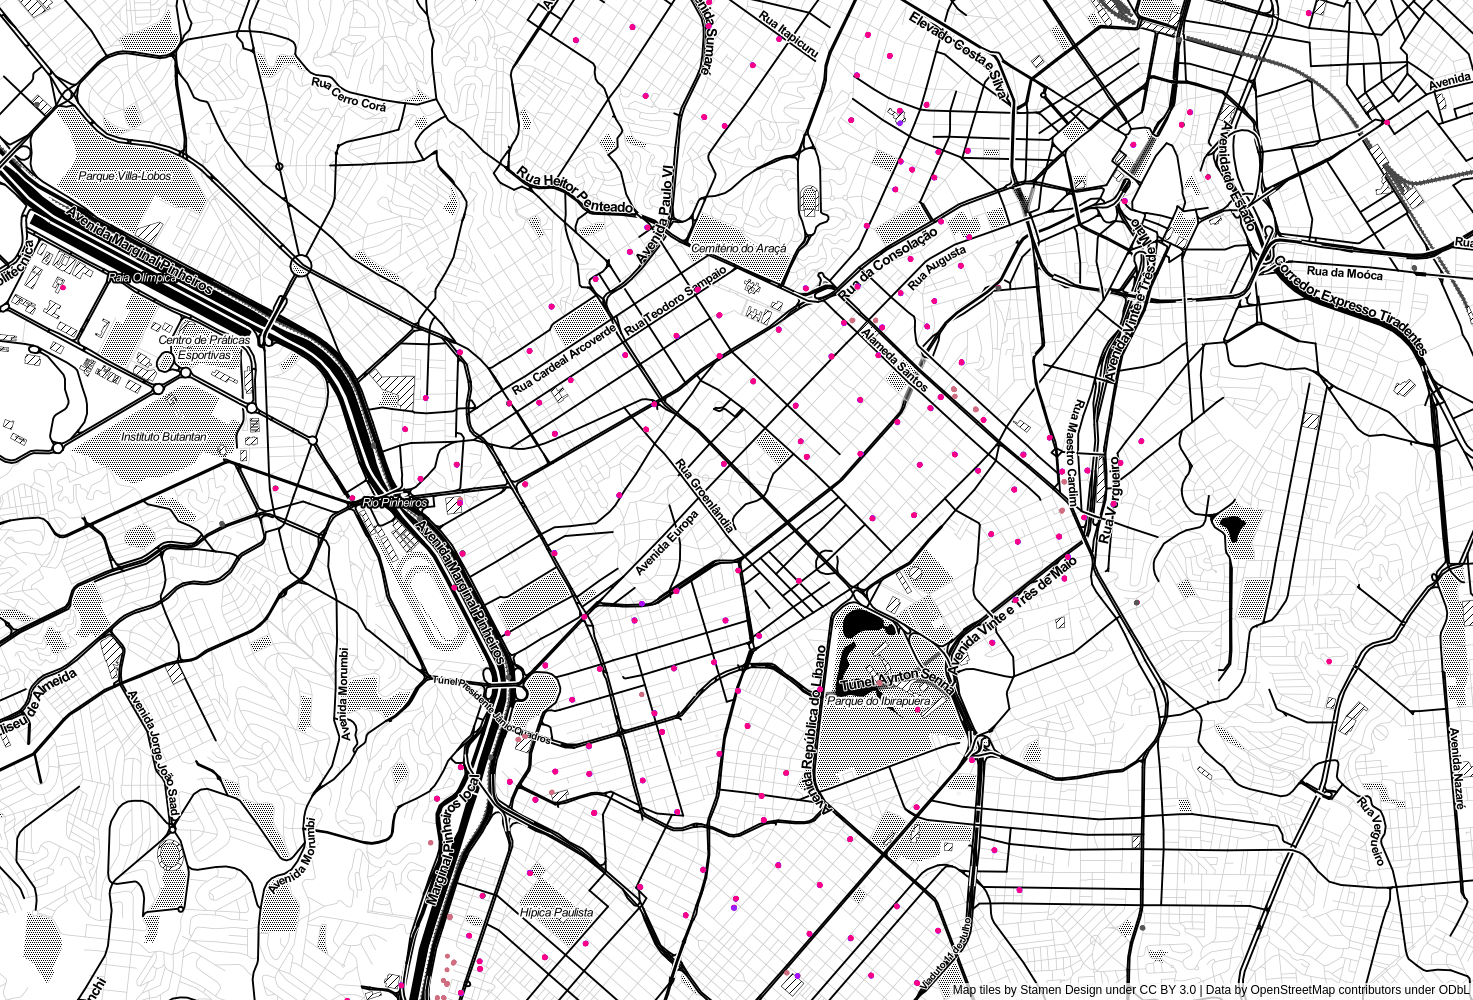

In [16]:
import plotly.express as px

df = ERBs_SP_CLARO[(ERBs_SP_CLARO.distance < 8000) & (ERBs_SP_CLARO.Tecnologia == 'NR')].copy()
df.Latitude = df.Latitude.apply(lambda val: val + random.random() / 10**4)
df.Longitude = df.Longitude.apply(lambda val: val + random.random() / 10**4)

fig = px.scatter_mapbox(df, lat='Latitude', lon='Longitude', hover_name='NumEstacao', color='FreqTxMHz',
                        color_continuous_scale=px.colors.qualitative.Alphabet,
                        size_max=20, zoom=13)
fig.update_layout(
    mapbox=dict(
        style=
        #'carto-darkmatter'
        #'carto-positron'
        #'open-street-map'
        'stamen-toner'
        #'stamen-watercolor'
        #'white-bg'
        ,
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    width=1000, height=1000,
)
fig.update_coloraxes(showscale=False)

Dessa vez, o Dataframe auxiliar possui as ERBs 5G mais próximas de 2000m e a visualização considera o azimute das antenas

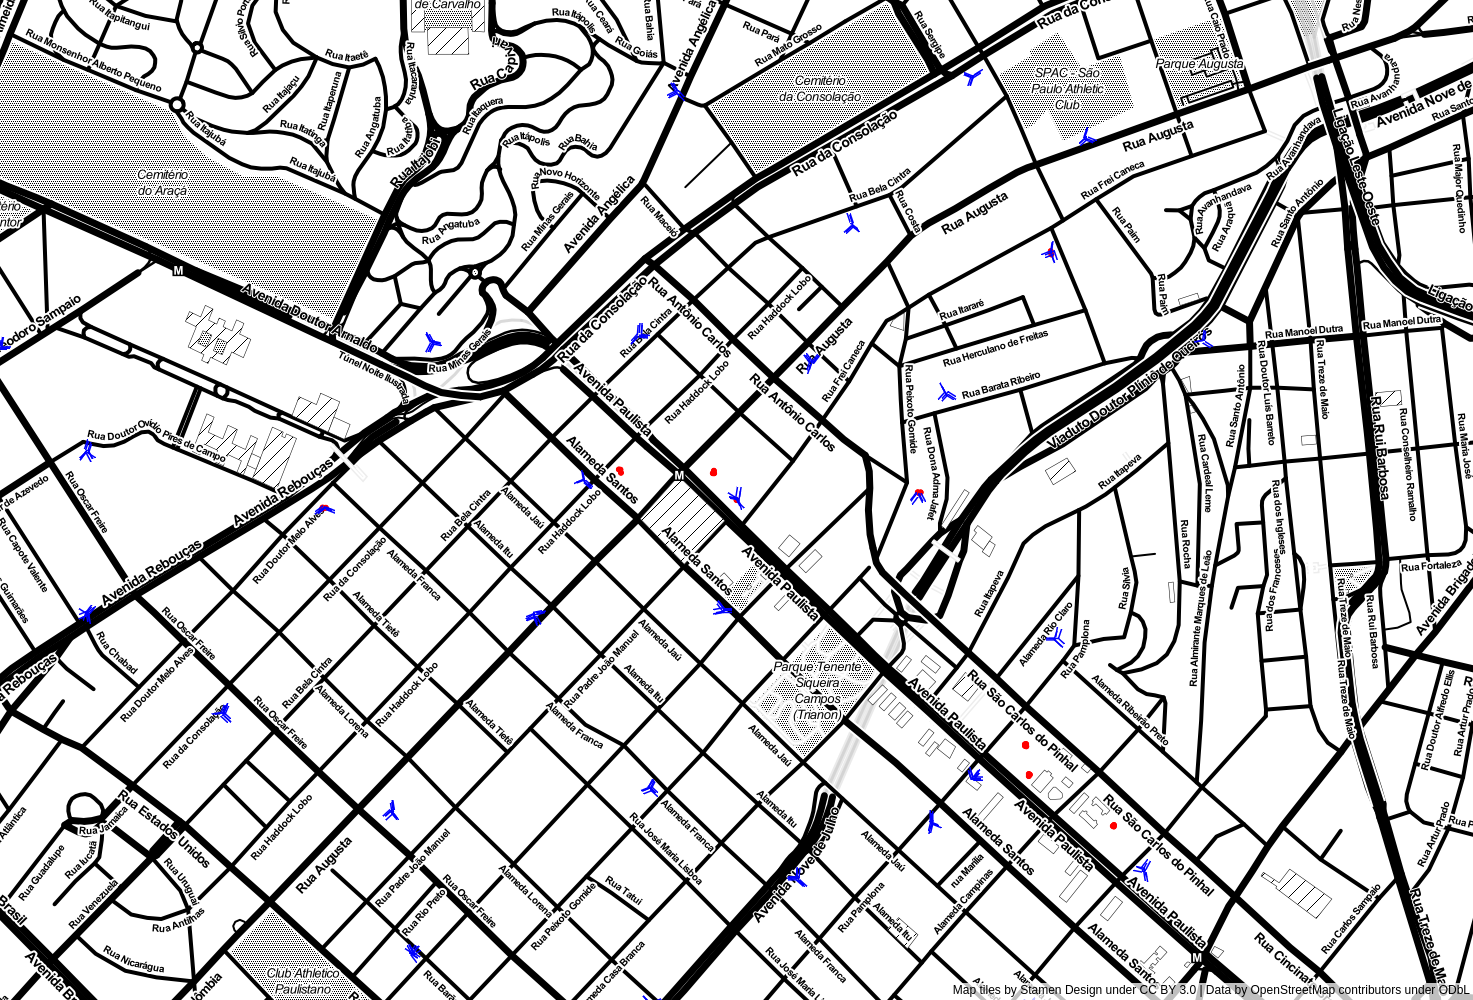

In [17]:
import plotly.graph_objs as go

df = ERBs_SP_CLARO[(ERBs_SP_CLARO.distance < 2000) & (ERBs_SP_CLARO.Tecnologia == 'NR')].copy()
df.Latitude = df.Latitude.apply(lambda val: val + random.random() / 10**4)
df.Longitude = df.Longitude.apply(lambda val: val + random.random() / 10**4)

fig = go.Figure()

dfDot = df[df.Azimute == 0] # omnidirectional
fig.add_trace(go.Scattermapbox(
    lat=dfDot.Latitude,
    lon=dfDot.Longitude,
    mode='markers',
    marker=dict(size=7, color='red', symbol='circle'),
))

# see: https://plotly.com/python/lines-on-maps/#performance-improvement-put-many-lines-in-the-same-trace
dfLine = df[df.Azimute != 0] # directional
line_size = .0002
lats = np.empty(3 * len(dfLine))
lats[::3] = dfLine.Latitude
lats[1::3] = dfLine.Latitude + line_size * np.cos(dfLine.Azimute_rad)
lats[2::3] = None

lons = np.empty(3 * len(dfLine))
lons[::3] = dfLine.Longitude
lons[1::3] = dfLine.Longitude + line_size * np.sin(dfLine.Azimute_rad)
lons[2::3] = None

fig.add_trace(go.Scattermapbox(
    lat = lats,
    lon = lons,
    mode = 'lines',
    line = dict(width = 1.5, color = 'blue'),
))

fig.update_layout(
    mapbox=dict(
        style=
        #'carto-darkmatter'
        #'carto-positron'
        #'open-street-map'
        'stamen-toner'
        #'stamen-watercolor'
        #'white-bg'
        ,
        center=dict(lat=df.Latitude.iloc[0], lon=df.Longitude.iloc[0]),
        zoom=15,
    ),
    showlegend=False,
    margin=dict(l=0, r=0, t=0, b=0),
    width=1000, height=1000,
)